In [1]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())


E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [4]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


## 2_SeasonalSPI

In [8]:
mdl=1
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE','RE_cleaned']
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]

ds_RM = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_reg_ssn_SPI1.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
basin=ds_RM.region.values

0.83

C:\Users\sstar\AppData\Local\Temp\ipykernel_8892\4234220729.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["slope"][i]=slope
C:\Users\sstar\AppData\Local\Temp\ipykernel_8892\4234220729.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p_value"][i]=p


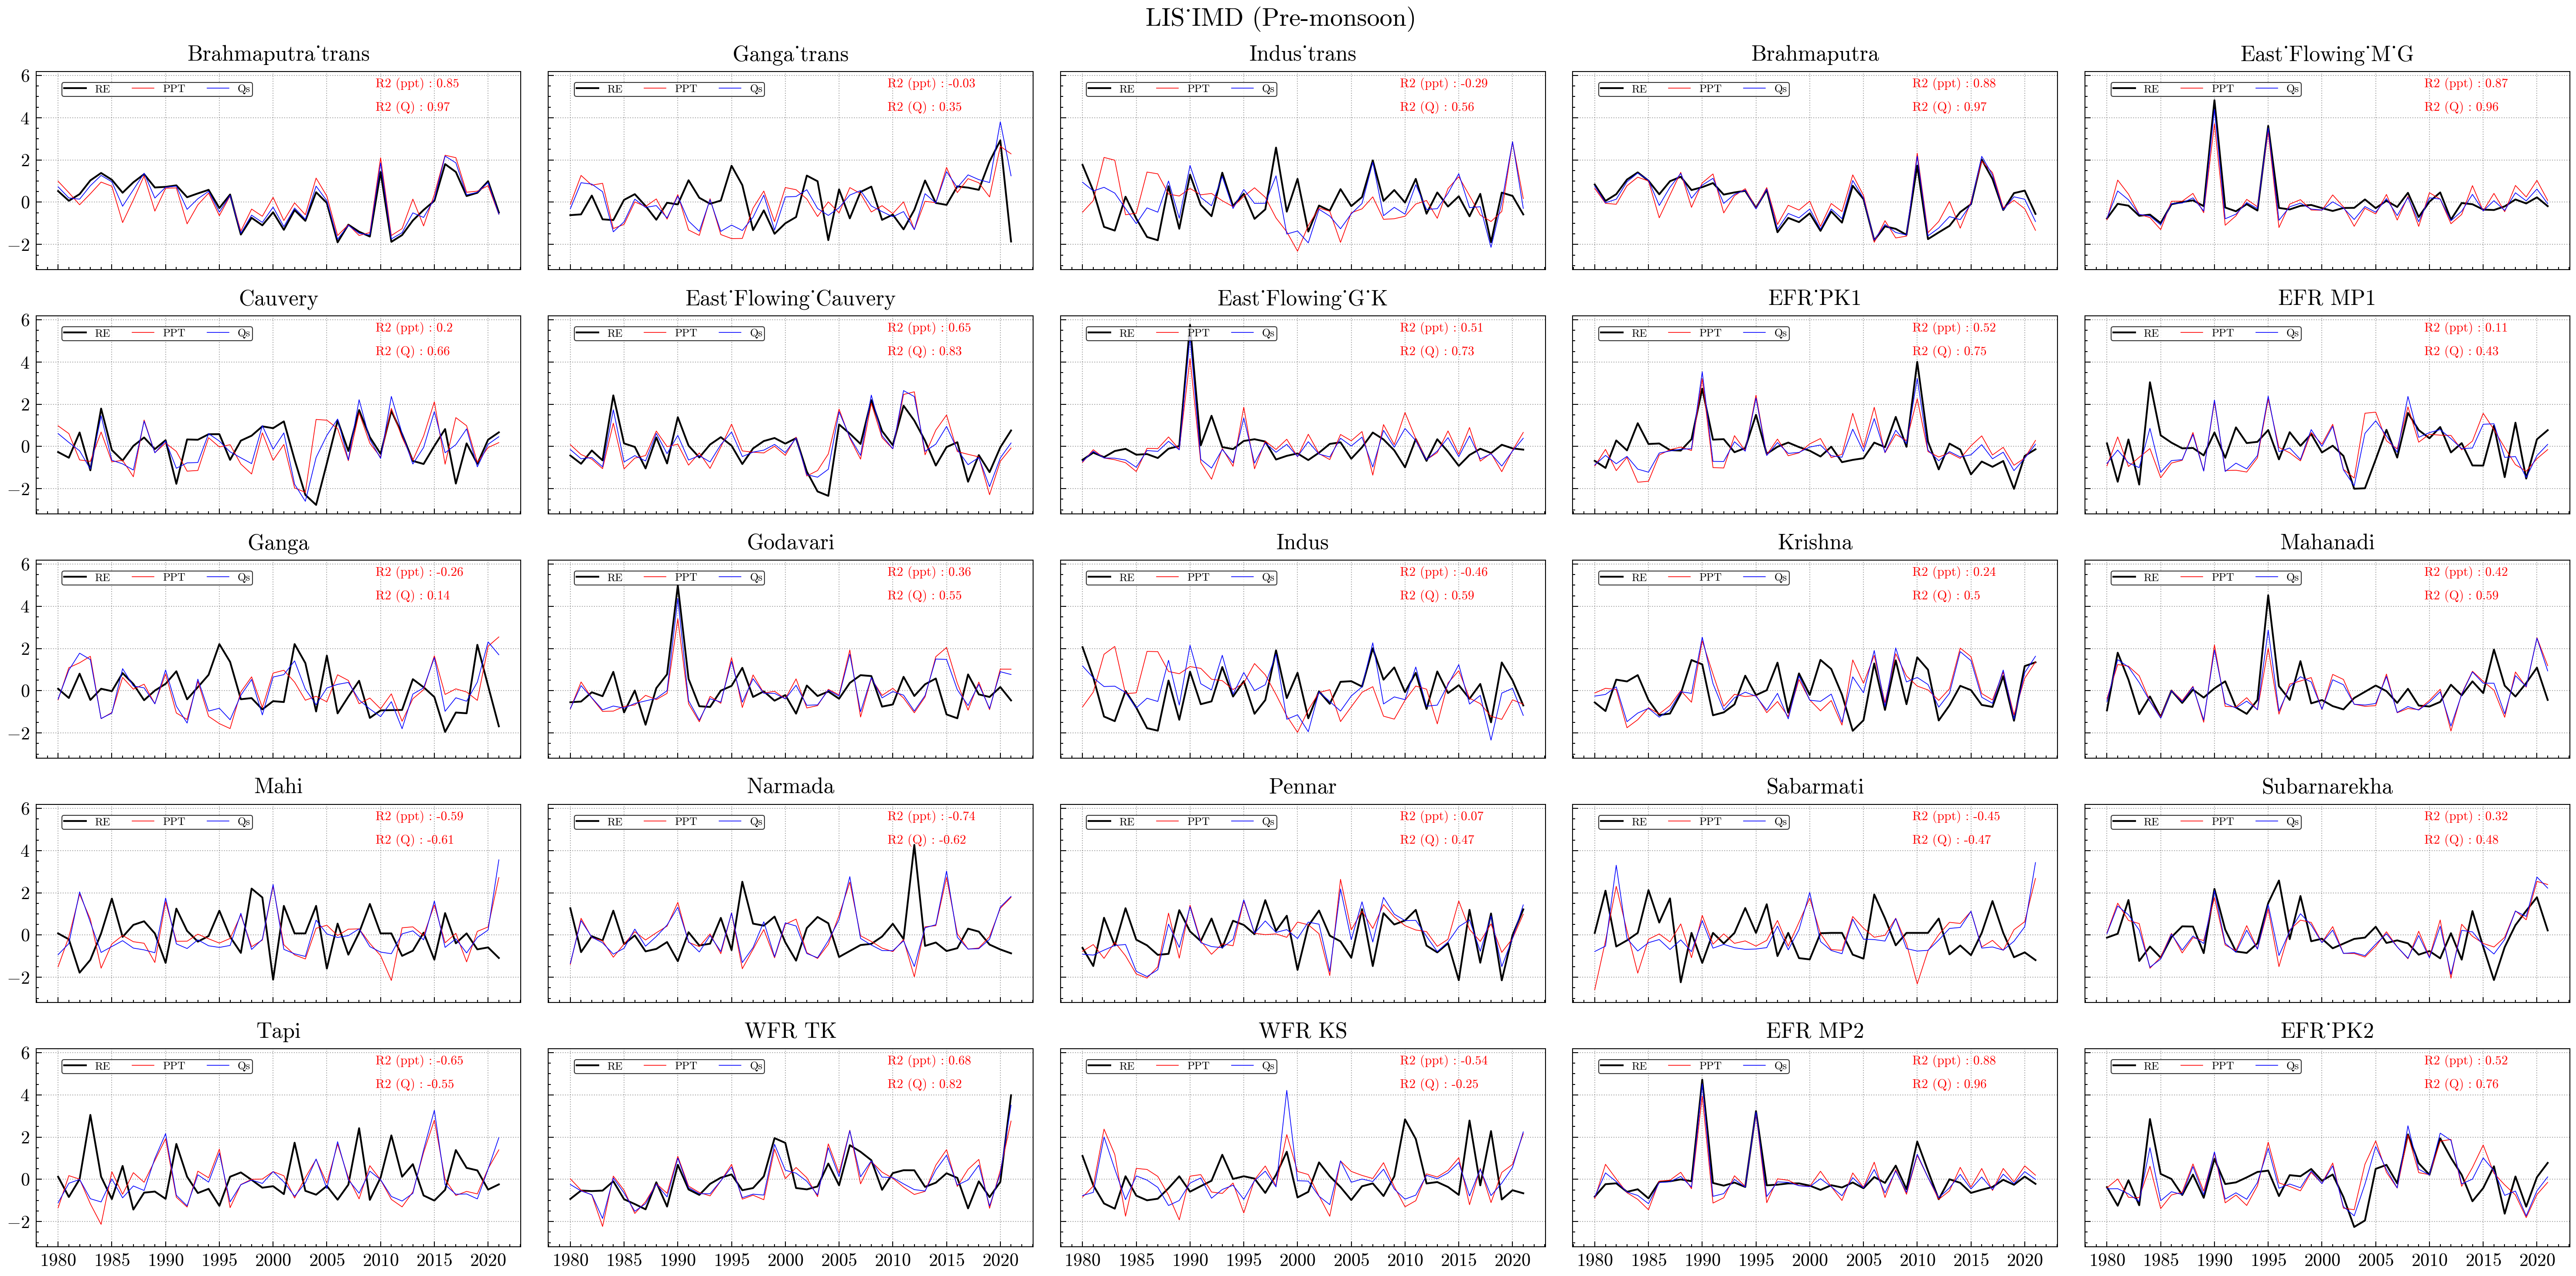

In [10]:
import pymannkendall as mk
from sklearn.linear_model import LinearRegression

ss=0

var=['Tot alPrecip_tavg','Evap_tavg','Qs_tavg','RE','RE_cleaned']
#var=[f'SPI_{i}' for i in var]
vr=3
df = pd.DataFrame({"Basin" : basin, "slope": 0, "p_value": 0})
result=[]
for i in range(0,len(basin)):
    
    ds_RM1=ds_RM.isel(season=ss)
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(ds_RM1[var[vr]].sel(region=basin[i]))
    df["slope"][i]=slope
    df["p_value"][i]=p


    model1=LinearRegression().fit(ds_RM1.year.values.reshape(-1, 1) , ds_RM1[var[vr]].sel(region=basin[i]).values)
    y_pred = model1.predict(ds_RM1.year.values.reshape(-1, 1))
    result.append(y_pred)

df["sign"] = np.where(df["p_value"] < 0.05, "Trend", "No Trend")
df["colour"] = np.where(df["p_value"] < 0.05, np.where(df["slope"] < 0,"lightyellow", "lightgreen"),"white")
reg_line=xr.DataArray(np.array(result).T, dims=('year', 'region')) 
ds_RM1 = xr.merge([ds_RM1, reg_line.rename("reg_line")])



fig, ax = plt.subplots(5,5,figsize=(20,10), facecolor='white', dpi=300,sharex=True, sharey=True)
ax=ax.flatten()

for i in range(25):
        
    import scienceplots
    plt.style.use(['science','no-latex','bright'])
    
    yr=ds_RM1.year
    re=ds_RM1[var[vr]].isel(region=i)
    re_s=ds_RM1['reg_line'].isel(region=i)
   
    ppt=ds_RM1['TotalPrecip_tavg'].isel(region=i)
    qs=ds_RM1['Qs_tavg'].isel(region=i)
    lw=1;al=1
    
    ax[i].plot(yr, re, color='Black', label='RE', alpha=al, linewidth=lw)
    #ax[i].plot(yr, re_s, color='red', label='Trend', alpha=al, linewidth=lw)
    
    ax[i].plot(yr, ppt, color='red', label='PPT', alpha=al, linewidth=0.4)
    ax[i].plot(yr, qs, color='blue', label='Qs', alpha=al, linewidth=0.4)
    
    plt.xticks(np.arange(1980, 2020+1, 5.0))
    ax[i].grid(True, color= 'grey', alpha=0.7, linestyle='dotted')
    #ax[i].set_facecolor(df['colour'][i])  

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax[i].xaxis.set_tick_params(which='both', bottom=True, top=False)
    ax[i].yaxis.set_tick_params(which='both', left=True, right=False)
    
    
    ax[i].text(0.7, 0.97,f"R2 (ppt) : {np.corrcoef(ppt,re)[0,1].round(2)} ", fontsize=7, color='red',
         ha='left', va='top', transform=ax[i].transAxes)

    ax[i].text(0.7, 0.85,f"R2 (Q) : {np.corrcoef(qs,re)[0,1].round(2)}", fontsize=7, color='red',
         ha='left', va='top', transform=ax[i].transAxes)

    #ax[i].text(0.2, 0.5,f"R2 (Q) : {np.corrcoef(qs,re)[0,1].round(2)}", fontsize=7, color='red',
      #   ha='left', va='top', transform=ax[i].transAxes)

    
    
    #ax[i].set_xlabel('$\mathbf{Year}$', fontsize=14)
    #ax[i].set_ylabel('RE', fontsize=14,labelpad=8, weight='bold')
    ax[i].set_title(f'{basin[i]}', fontsize=12)
    
    lgnd=ax[i].legend(loc='center', ncol=3,fontsize=6, bbox_to_anchor=(0.25, 0.91),frameon=True, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.5)
    fig.suptitle(f'{model[mdl]} ({ssn[ss]})', fontsize=14,fontweight='bold')

plt.tight_layout()
plt.savefig(f'2_RE analysis/4_REregional/{model[mdl]}_{ssn[ss]}.png')
plt.show()